# Chapter 3: Classification
Notes for *Hands on Machine Learning with Scikit by Aurelien Geron*. This is on Chapter 3: Classification, where it explains the fundamentals on how Machine Learning identify one group from the other using statistics.

# Getting Started
The dataset used is the *MNIST*, which is a collection of handwritten numbers in the format of image pixels. The goal is to have the machine tell us what number is in each image.

In [1]:
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
pd.options.display.max_rows = 1000; pd.options.display.max_columns = 100;

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

You can download a copy of the dataset from sklearn. This gets updated often, which is why it is different on the book.

In [3]:
df, target = mnist["data"], mnist["target"]

There are 2 sets of data. *Data* contains the pixel information about the number image, which is what we will use to predict. *Target* are the answer keys, which tells us what the number is.

In [4]:
print('data', df.shape) # I store the data info in df, which is short for dataframe.
print('target', target.shape) 

data (70000, 784)
target (70000,)


In [5]:
df.iloc[0].describe()

count    784.000000
mean      35.108418
std       79.699674
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      255.000000
Name: 0, dtype: float64

There are 70,000 numbers in the dataset and each number holds 784 pixels. Each pixel has a value between 0 to 255, which indicates the intensity of the black color. 

## Split Train Test
Before we begin, we set aside a portion of the dataset into a *Test* set, which is what we use at the very end to validate our models. We use the *Train* for majority of our exploration and data engineering.

In [6]:
train_df, test_df, train_target, test_target = df[:60000], df[60000:], target[:60000], target[60000:]

The MINST dataset is already dividied into Train and Test. The first 60k rows is the Train and the rest are the Test.

In [7]:
import numpy as np
shuffle_index = np.random.RandomState(seed=42).permutation(60000)
train_df, train_target = train_df.iloc[shuffle_index], train_target.iloc[shuffle_index]

There is a chance that the numbers are in order in a way that it will affect our models. Like a new deck of cards, we would always shuffle it before using them. Here, we shuffle it using the index.

# Explore Data
Our data is prepapred. It is time to Explore, Clean and Machine Learning the shit out of it. 

I don't restrict myself from exploring the data but I do keep everything organized. That is why I keep Exploring, Cleaning and Machine Learning code in separate sections in this order. This section is where we keep all our Exploring data.

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
seven = train_df.loc[59963].values

The numbers will keep shuffling everytime you run the code. Better choose a number and remember the index so you can iterate over the same number. Here I choose the number 7, which has an index of 59963 as an example.

7


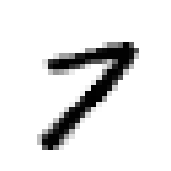

In [9]:
seven_target = train_target.loc[59963] # Choose a number and remember the index because of the shuffle.
print(seven_target)
plt.figure(figsize=(2,2))
number_seven_image = seven.reshape(28, 28)
plt.imshow(number_seven_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Each row contains pixel information about a number. If it reshaped into 28 by 28 pixels and plotted in a graph, the image of the number will show. We have chosen the number seven and true enough the image is a seven.

# Clean Data
In this section, we Clean the data.

In [10]:
import numpy as np
train_target = train_target.astype(np.uint8)
test_target = test_target.astype(np.uint8)

The values of each targets are strings. We want them as intigers.

# Machine Learning
In this section, we do our Machine Learning algorithms. We start with an easy algorithm, then we work our way up to the more complex ones.

## Stochastic Gradient Descent
The goal is to use the pixel information in each row to tell us what number it is. But before doing all numbers, we start with something simple, which is to determine if the number is seven or not (TRUE or FALSE). For our first model, we use SGD that is great at classifying large datasets.

In [11]:
train_target_seven = (train_target == int(seven_target))

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) # Init. Call on SGD.
sgd_clf.fit(train_df, train_target_seven) # Fit. We give instructions to Machine.
sgd_clf.predict([seven]) # Predict. Ask machine if seven is the number seven.

array([ True])

Pay attention here because this is how all Machine Learning Algorithm works:
- Init. We create an instance of the model.
- Fit. We give the machine the data and the answer keys for it to learn.
- Predict. Then the machine uses what it learned from Fit to check if the Machine can tell if variable *seven* is seven. In this case, it does and it outputs the value *True*.

Now, let us check if the Machine can tell if the rest of the numbers are seven and check the accuracy.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, train_df, train_target_seven, cv=3, scoring="accuracy")

array([0.97725, 0.9779 , 0.97535])

*cross_val_score* splits the training data into 3 folds and uses 2 folds as training data and 1 fold as the test. It does this 3 times in different combination. 

Results show that on average, the model is accurate around ~95% of the time. This is unusually high. Let us try another dumber model and check.

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_roll_clf = Never5Classifier()
cross_val_score(never_roll_clf, train_df, train_target_seven, cv=3, scoring="accuracy")

array([0.89245, 0.89785, 0.89645])

Again, we get very high results. This is because ~90% of the numbers are not sevens. So, if the model is lazy and said that all numbers are not seven, then it would be correct 90% of the time and it would give it a accuracy score of 90%. This is why accuracy, as a measure of classification, sucks.

## Confusion Matrix
Instead just counting the correct predictions, Confusion Matrix also takes into account the wrong predictions. This creates balance in the way we evaluate our models.

In [16]:
from sklearn.model_selection import cross_val_predict
train_pred_seven = cross_val_predict(sgd_clf, train_df, train_target_seven, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_target_seven, train_pred_seven)

array([[52997,   738],
       [  652,  5613]], dtype=int64)

#### 
![confusion_matrix](image1.svg)

**Precision** is the number of times the model predicted that the number was seven versus all the predictions that it thought was seven. **Recall** is the number of times the model predicted that the number was seven versus all the actual sevens that exists in the dataset.

Precision alone is not enough to evaluate a model. If say the model had only 1 True prediction, which happens to be a seven, then your precision is 100%. Recall is also not useful either by itself. It is possible to get a 100% recall if the model predicted that ALL numbers are sevens, which gives you a Recall of 100%.

There are some use cases where you would prioritize one metric over the other but, generally, you want to have both Precision and Recall to be both high. 

In [18]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(train_target_seven, train_pred_seven)
precision

0.8837978271138404

For our model, it has a 90% precision score, which means that out 5,992 numbers that it has identified as the number seven, only 5,402 of those wer actually the number seven. This is pretty good.

In [19]:
recall = recall_score(train_target_seven, train_pred_seven)
recall

0.8959297685554669

But it has scored a recall of 86%, which means that the 5,402 correct predictions are only 86% of all actual sevens. It was not able to identify 863 that were also sevens.

## F1 score
The F1 score is a convinient measure that calculates the *harmonic mean* of precision and recall.

In [20]:
from sklearn.metrics import f1_score
print('f1: ', f1_score(train_target_seven, train_pred_seven))

f1:  0.8898224476854788


This is different from just averaging the 2 scores, instead it calculates it in a way that gives more weight to low values. There are tradeoffs between precision and recall. You cannot increase one metric without decreasing the other.

Increasing Precision is actually telling the model to make predictions that has the least wrong answers, even if it does not get all the sevens in the dataset. Conversely, if Recall is prioritized, then the model needs to make sure that it gets all sevens in the dataset even if it mistakenly predict some numbers to be seven.

## Threshold
To better understand the tradeoffs between precision and recall, we are going to tweak the threshold of the models. By default, SGD's threshold is at zero, which finds the optimized scores between the 2 metrics.

In [21]:
target_score = sgd_clf.decision_function([seven])
target_score

array([7866.93916507])

We use the *decision_function* method of sgd to get the score of how well the model identifies the number data as seven.

In [22]:
threshold = 0
seven_pred = (target_score > threshold)
seven_pred

array([ True])

If we leave the threshold at zero, then we get a True output.

In [23]:
threshold = 8000
seven_pred = (target_score > threshold)
seven_pred

array([False])

If we set the threshold at 8000, then we get an output of False. This means that to the machine, the number does not enough score to be identified as the number seven.

In [24]:
target_scores = cross_val_predict(sgd_clf, train_df, train_target_seven, cv=3, method='decision_function')

In [25]:
pd.DataFrame({
    'target': train_target,
    'answer': train_target_seven,
    'scores': target_scores
}).query('target==7').sort_values(by='scores', ascending=False).head()

,target,answer,scores
37665,7,True,48163.256141
23000,7,True,43371.436501
21514,7,True,41118.024888
13244,7,True,40826.558944
26417,7,True,40338.274713


If the score is ran on all the numbers on our train set, we get the corresponding score. Here is a preview.

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(train_target_seven, target_scores)

In [27]:
f1_score(train_target_seven, train_pred_seven)

0.8898224476854788

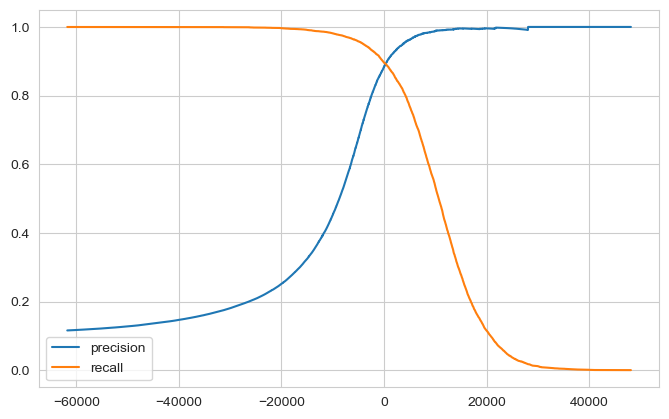

In [28]:
plt.figure(figsize=(8,5))
sns.lineplot(x=threshold, y=precisions[:-1], label='precision')
sns.lineplot(x=threshold, y=recalls[:-1], label='recall')
plt.legend();

Here, we get to see precision and recall against there threshold. It is at threshold zero that we see the 2 lines intersect. This is where we will find the optimized scores for both precision and recall.

## ROC Curve
We can adjusting threshold to get different combination of precision and recall. But if you just want to evaluate the strength of your model on how it can predict something, then you would look at something like the ROC curve.

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train_target_seven, target_scores)

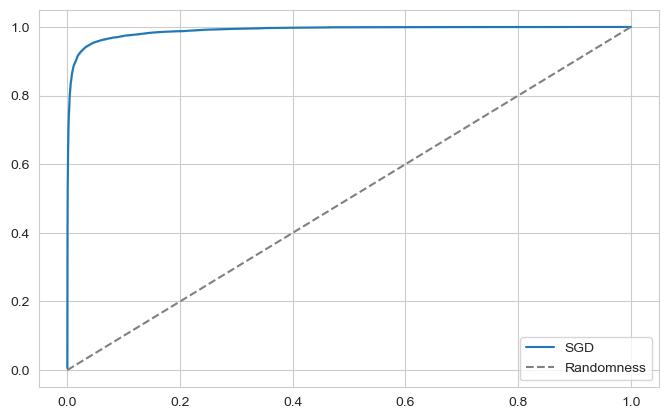

In [30]:
plt.figure(figsize=(8,5))
sns.lineplot(x=fpr, y=tpr, label='SGD')
sns.lineplot(x=[0,1], y=[0,1], color='grey', linestyle='--', label='Randomness')
plt.legend();

The ROC curve plots the False Positive Rate on the x-axis and the True Positive rate on the y-axis. The FPR is the number of times the model says the numbers are sevens but are actually were not over all the Positive predictions it made. While the TPR is just the same as Recall. The ROC only cares about the Predictions that the model make as being TRUE and gauges the effectiveness of that model as it would a binomial distribution, whereby it determines how often it will get the right answer (TPR) against how likely it is to get the wrong answer (FPR). It disregards the FALSE output or the NEGATIVE output the model.

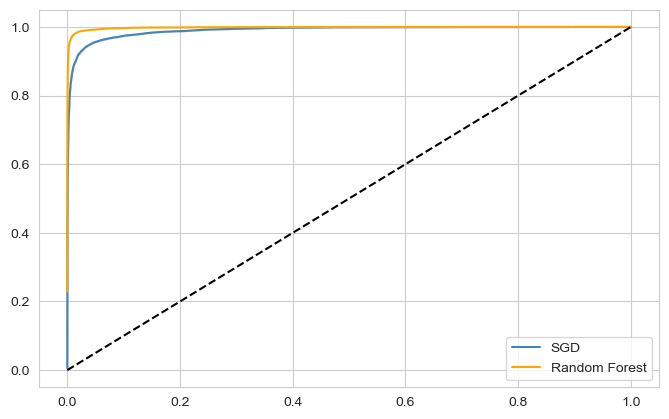

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
probas_forest = cross_val_predict(forest_clf, train_df, train_target_seven, cv=3, method='predict_proba')

target_scores_forest = probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(train_target_seven, target_scores_forest)

plt.figure(figsize=(8,5))
g = sns.lineplot(x=fpr, y=tpr, label='SGD', color='steelblue')
g = sns.lineplot(x=fpr_forest, y=tpr_forest, label='Random Forest', color='orange')
g = sns.lineplot(x=[0,1], y=[0,1], linestyle='--', color='black')
plt.savefig('roc.svg')

Here, we train a Random Forest model and place it against the SGD model in the same ROC plot. How ROC curve works is that the model should be as high up on the top left corner of the graph as possible. Comparing the 2 models, we get to see that the Random Forest Model is much better classifier than the SGD.

The dashed diagonal line in the middle represents randomness. If the model gets closer to that line, it means that it is no better at classifying than a coin flip.

In [32]:
from sklearn.metrics import roc_auc_score
print('SGD', roc_auc_score(train_target_seven, target_scores))
print('RandomForest', roc_auc_score(train_target_seven, target_scores_forest))

SGD 0.989954367264912
RandomForest 0.9981929410171149


To summarize the results of both models to just one number, it is often easy to just caculate the area under the ROC curve and compare those instead of plotting it on a graph. Here, Random Forest is truely better model than the SGD.

## Multiclass Classification

In [42]:
sgd_clf.fit(train_df, train_target)
sgd_clf.predict([seven])

array([7], dtype=uint8)

In [44]:
seven_scores = sgd_clf.decision_function([seven])

In [46]:
seven_scores

array([[-30680.33084323, -13285.00601243,  -6158.77253929,
         -7122.94195392, -18767.48190138,  -5392.96787129,
        -29211.19870979,   9929.67761202,    221.57103558,
         -6950.30435848]])

In [47]:
np.argmax(seven_scores)

7

In [48]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [49]:
sgd_clf.classes_[7]

7

In [50]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(train_df, train_target)
ovo_clf.predict([seven])

array([7], dtype=uint8)

In [52]:
len(ovo_clf.estimators_)

45

In [54]:
forest_clf.fit(train_df, train_target)
forest_clf.predict([seven])

array([7], dtype=uint8)

In [55]:
forest_clf.predict_proba([seven])

array([[0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.96, 0.02, 0.01]])

In [56]:
cross_val_score(sgd_clf, train_df, train_target, cv=3, scoring='accuracy')

array([0.8678 , 0.88195, 0.86965])

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df.astype(np.float64))
cross_val_score(sgd_clf, train_df_scaled, train_target, cv=3, scoring='accuracy')

array([0.90425, 0.9031 , 0.8903 ])

# Error Analysis

In [58]:
train_target_pred = cross_val_predict(sgd_clf, train_df_scaled, train_target, cv=3)
conf_mx = confusion_matrix(train_target, train_target_pred)
conf_mx

array([[5577,    0,   19,    5,   10,   39,   33,    5,  234,    1],
       [   1, 6413,   44,   17,    4,   45,    4,    8,  198,    8],
       [  23,   32, 5249,   88,   71,   20,   62,   39,  366,    8],
       [  27,   20,  115, 5216,    0,  197,   24,   44,  425,   63],
       [   7,   14,   46,   11, 5216,    8,   35,   20,  331,  154],
       [  28,   19,   31,  141,   52, 4466,   78,   18,  523,   65],
       [  27,   16,   50,    2,   39,   87, 5564,    7,  126,    0],
       [  20,   11,   52,   23,   50,   10,    4, 5702,  190,  203],
       [  18,   60,   42,  101,    2,  120,   32,   12, 5425,   39],
       [  22,   21,   29,   62,  123,   35,    1,  170,  361, 5125]],
      dtype=int64)

In [59]:
conf_mx.style.bar()

AttributeError: 'numpy.ndarray' object has no attribute 'style'